# ENV

In [ ]:
!pip install -q lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 24.8 MB/s eta 0:00:00


In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

from einops.layers.torch import Rearrange, Reduce
from einops import reduce, repeat, rearrange, einsum, parse_shape, pack, unpack

In [ ]:
import seaborn as sns
sns.set()

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth']=2

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')

In [ ]:
import lightning as L

In [ ]:
L.seed_everything(42)
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benmark=False
device='cuda' if torch.cuda.is_available() else 'cpu'
device

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


'cpu'

# Data

In [ ]:
from torch.utils.data import random_split
from torchvision import transforms
from torchvision.datasets import MNIST, CelebA


class DataModule(L.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size=batch_size
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])
        self.shape=[1,28,28]
        self.num_classes=10

    def setup(self, stage=None):
        if stage=='fit' or stage is None:
            dataset = MNIST('.', download=True, train=True, transform=self.transform)
            self.train, self.val = random_split(dataset, [55000, 5000])

        if stage=='test' or stage is None:
            self.test = MNIST('.', download=True,train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, drop_last=True)

tmp=DataModule(16)
tmp.setup()
batch=next(iter(tmp.train_dataloader()))
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)

2
torch.Size([16, 1, 28, 28])
torch.Size([16])


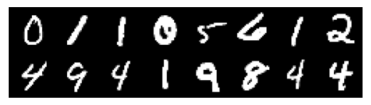

In [ ]:
from torchvision.utils import make_grid

def show_image(images, num_images=16, image_size=[1,28,28]):
    images=images.detach().cpu()
    grid_image=make_grid(images[:num_images], nrow=8)
    plt.imshow(grid_image.permute(1,2,0))
    plt.axis('off')
    plt.show()

show_image(batch[0])

# Architecture

In [ ]:
class MappingLayer(nn.Module):
    def __init__(self, z_dim, hidden_dim, w_dim):
        super().__init__()
        self.layer = nn.Sequential(nn.Linear(z_dim, hidden_dim),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(hidden_dim, hidden_dim),
                                   nn.ReLU(inplace=True),
                                   nn.Linear(hidden_dim, w_dim))

    def forward(self, x):
        return self.layer(x)

In [ ]:
class Injector(nn.Module):
    def __init__(self,channels):
        super().__init__()
        self.weight=nn.Parameter(torch.randn(1, channels, 1, 1))

    def forward(self, x):
        b, c, h, w = x.shape
        noise=torch.randn([b,1,h,w], device=x.device)
        return x+self.weight*noise

x=torch.randn([1, 256, 2, 2])
tmp=Injector(256)
tmp(x).shape

torch.Size([1, 256, 2, 2])

In [ ]:
#Adaptive instance normalization
class AdaIN(nn.Module):
    def __init__(self, channels, w_dim):
        super().__init__()
        self.norm = nn.InstanceNorm2d(channels)
        self.style_scale = nn.Linear(w_dim, channels)
        self.style_shift = nn.Linear(w_dim, channels)

    def forward(self, x, w):
        x=self.norm(x)

        style_scale=self.style_scale(w)[:, :, None, None]
        style_shift=self.style_shift(w)[:, :, None, None]

        x=style_scale*x+style_shift

        return x

In [ ]:
class GenBlock(nn.Module):
    def __init__(self,in_channels, out_channels, w_dim, kernel_size, starting_size, use_upsample=True):
        super().__init__()
        self.use_upsample=use_upsample
        if self.use_upsample:
            self.up_sample = nn.Upsample([starting_size, starting_size], mode='bilinear')

        self.conv=nn.Conv2d(in_channels, out_channels, kernel_size, padding=1)
        self.injector=Injector(out_channels)
        self.adain=AdaIN(out_channels, w_dim)

    def forward(self, x, w):
        if self.use_upsample:
            x=self.up_sample(x)

        x=self.conv(x)
        x=self.injector(x)
        x=self.adain(x, w)
        x=F.leaky_relu(x, inplace=True)
        return x

x= torch.randn([1, 512, 4, 4])
w=torch.randn([7, 496])
tmp=GenBlock(512,256,496,4,3)
tmp(x,w).shape

torch.Size([7, 256, 2, 2])

In [ ]:
class StyleGAN(nn.Module):
    def __init__(self, z_dim, hidden_dim, w_dim, in_channels, out_channels, kernel_size, hidden_channels):
        super().__init__()

        self.alpha=0.2
        self.mapping=MappingLayer(z_dim, hidden_dim, w_dim)
        self.starting_constant = nn.Parameter(torch.randn(1, in_channels, 4, 4))

        self.block0=GenBlock(in_channels, hidden_channels, w_dim, kernel_size, 4, use_upsample=False)
        self.block1=GenBlock(hidden_channels, hidden_channels, w_dim, kernel_size, 24)
        self.block2=GenBlock(hidden_channels, hidden_channels, w_dim, kernel_size, 28)

        self.block1_to_image=nn.Conv2d(hidden_channels, out_channels, kernel_size=1)
        self.block2_to_image=nn.Conv2d(hidden_channels, out_channels, kernel_size=1)

    def forward(self, noise):
        x=self.starting_constant
        w=self.mapping(noise)
        x=self.block0(x, w)

        x_small = self.block1(x, w)
        x_small_image = self. block1_to_image(x_small)

        x_big=self.block2(x,w)
        x_big_image = self.block2_to_image(x_big)

        x_small_upsample = F.interpolate(x_small_image, size=x_big_image.shape[-2:], mode='bilinear')

        interpolation=self.alpha*x_big_image+(1-self.alpha)*x_small_upsample

        return interpolation

x=torch.randn([7,128])
tmp=StyleGAN(z_dim=128, hidden_dim=1024, w_dim=496,
               in_channels=512, hidden_channels=256,out_channels=1, kernel_size=3)
tmp(x).shape

torch.Size([7, 1, 28, 28])

In [ ]:
class DiscBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=4, stride=2):
        super().__init__()
        self.layer=nn.Sequential(nn.utils.spectral_norm(nn.Conv2d(in_channels, out_channels, kernel_size, stride)),
                                 nn.BatchNorm2d(out_channels),
                                 nn.SiLU(inplace=True))
    def forward(self,x):
        return self.layer(x)

class Discriminator(nn.Module):
    def __init__(self, image_channel, hidden_dim):
        super().__init__()
        self.disc=nn.Sequential(DiscBlock(image_channel, hidden_dim),
                                DiscBlock(hidden_dim, hidden_dim*2),
                                nn.utils.spectral_norm(nn.Conv2d(hidden_dim*2, 1, kernel_size=4,stride=2)),
                                Rearrange('b c h w -> b (c h w)'))

    def forward(self, x):
        return self.disc(x)


x=torch.rand([7,13,28,28])
tmp=Discriminator(13,14)
tmp(x).shape

torch.Size([7, 1])

# Training

In [ ]:
class GAN(L.LightningModule):
    def __init__(self, z_dim, hidden_dim, w_dim, in_channels, hidden_channels, kernel_size, image_size,learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        self.automatic_optimization=False

        self.gen=StyleGAN(z_dim=z_dim, hidden_dim=hidden_dim, w_dim=w_dim,
                          in_channels=512, out_channels=image_size[0], kernel_size=kernel_size, hidden_channels=hidden_channels)
        self.disc=Discriminator(image_size[0], 16)

    def forward(self,x):
        return self.gen(x)

    def criterion(self, pred, y):
        return F.binary_cross_entropy_with_logits(pred, y)

    def training_step(self, batch):
        real=batch[0]
        labels=batch[1]

        gen_opt, disc_opt=self.optimizers()

        self.toggle_optimizer(disc_opt)
        noise=torch.randn([real.shape[0], self.hparams.z_dim], device=self.device)
        fake=self.gen(noise).detach()
        fake_pred=self.disc(fake)
        real_pred=self.disc(real)

        fake_loss = self.criterion(fake_pred, torch.zeros_like(fake_pred))
        real_loss = self.criterion(real_pred, torch.ones_like(real_pred))
        disc_loss = (fake_loss+real_loss)/2

        fake_acc = reduce(((fake_pred.squeeze()<0.5)==labels).float(), 'b -> ()', 'mean').float()
        real_acc = reduce(((real_pred.squeeze()>=0.5)==labels).float(), 'b -> ()', 'mean').float()
        disc_acc = (fake_acc+real_acc)/2

        self.manual_backward(disc_loss)
        disc_opt.step()
        self.untoggle_optimizer(disc_opt)


        self.toggle_optimizer(gen_opt)
        gen_opt.zero_grad()
        noise=torch.randn([real.shape[0], self.hparams.z_dim], device=self.device)
        fake=self.gen(noise)
        pred=self.disc(fake)
        gen_loss = self.criterion(pred, torch.ones_like(pred))
        gen_acc = reduce(((pred.squeeze()<0.5)==labels).float(), 'b -> ()', 'mean').float()

        self.manual_backward(gen_loss)
        gen_opt.step()
        self.untoggle_optimizer(gen_opt)

        self.log("disc_loss", disc_loss.item(), prog_bar=True)
        self.log("disc_acc", disc_acc.item(), prog_bar=True)
        self.log("gen_loss", gen_loss.item(), prog_bar=True)
        self.log("gen_acc", gen_acc.item(), prog_bar=True)

    def configure_optimizers(self):
        gen_opt=torch.optim.Adam(self.gen.parameters(), lr=self.hparams.learning_rate)
        disc_opt=torch.optim.Adam(self.disc.parameters(), lr=self.hparams.learning_rate)

        return [gen_opt, disc_opt], []

    def on_train_epoch_end(self):
        noise=torch.randn([32,self.hparams.z_dim], device=self.device)
        fake=self.gen(noise)
        show_image(fake)

In [ ]:
import gc

gc.collect()
torch.cuda.empty_cache()

batch_size=1024
data_module=DataModule(batch_size)
model=GAN(z_dim=128, hidden_dim=1024, w_dim=496,
               in_channels=512, hidden_channels=256, kernel_size=3, image_size=[1,28,28],learning_rate=1e-3)
trainer=L.Trainer(
    accelerator='auto',
    devices=1,
    max_epochs=5,
    deterministic=True
)
trainer.fit(model, data_module)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | gen  | StyleGAN      | 4.8 M  | train
1 | disc | Discriminator | 9.1 K  | train
-----------------------------------------------
4.8 M     Trainable params
0         Non-trainable params
4.8 M     Total params
19.329    Total estimated model params size (MB)
47        Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name | Type          | Params | Mode 
-----------------------------------------------
0 | gen  | StyleGAN      | 4.8 M  | train
1 | disc | Discriminator | 9.

Training: |          | 0/? [00:00<?, ?it/s]

torch.Size([1024, 1, 28, 28])


INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

# Inference

In [ ]:
from scipy.stats import truncnorm

def get_truncated_noise(num_samples, z_dim, truncation=0.7):
    noise = truncnorm.rvs(-truncation, truncation, size=(num_samples, z_dim))
    return torch.Tensor(noise)

In [ ]:
x=get_truncated_noise(1,128)
fake=model(x)
plt.imshow(fake[0].permute(1,2,0))
plt.show()